In [1]:
import argparse
import torch
from numpy import dot
from numpy.linalg import norm
import wandb
import numpy as np
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer

/mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head

    #if args.uncertainty:
    cfg.MODEL.UNCERTAINTY = args.uncertainty

    #if args.pos:
    cfg.MODEL.POS = args.pos
    cfg.USE_CUDA = False
    
def setup_cfg(args):
    cfg = get_cfg_default()
    reset_cfg(cfg, args)
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./DATA', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='../output/dg/pacs/conststyle/cartoon', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    nargs='+',
    default='art_painting photo sketch'.split(),
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    nargs='+',
    default=['cartoon'],
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='../configs/trainers/dg/vanilla/pacs.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='../configs/datasets/dg/pacs_cs.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='ConstStyleTrainer', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
parser.add_argument('--uncertainty', default=0.0, type=float)
parser.add_argument('--pos', nargs='+', type=int, default=[],
                    help='pos for uncertainty')
parser.add_argument('--wandb', default=0, type=int, help='visualize on Wandb')
parser.add_argument('--option', default='', type=str, help='additional options')
parser.add_argument('--update_interval', default=20, type=int, help='update cluster interval')

args = parser.parse_args('')

In [4]:
cfg = setup_cfg(args)
if args.wandb:
    if 'u' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'DSU'
    elif 'c' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'ConstStyle'
    else:
        job_type = 'Baseline'
    if cfg.MODEL.BACKBONE.PRETRAINED:
        job_type += '-pretrained'
        
    tracker = wandb.init(
        project = 'StyleDG',
        entity = 'aiotlab',
        config = args,
        group = f'{cfg.DATASET.NAME}',
        name = f'train={cfg.DATASET.SOURCE_DOMAINS}_test={cfg.DATASET.TARGET_DOMAINS}_type={args.option}',
        job_type = job_type
    )
    args.tracker = tracker

if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

trainer = build_trainer(cfg, args)
device = torch.device('cpu')
trainer.model.backbone.to(device)

Setting fixed seed: 1
Loading trainer: ConstStyleTrainer
Loading dataset: PACS
Train dataset statistics| Domain [0 1 2] - count [1840 1499 3530] | Class: [0 1 2 3 4 5 6] - count [1204 1075 1096  879 1093  587  935]
Test dataset statistics| Domain [0] - count [2344] | Class: [0 1 2 3 4 5 6] - count [389 457 346 135 324 288 405]
Building transform_train
+ resize to 224x224
+ random flip
+ random translation
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building transform_test
+ resize to 224x224
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
***** Dataset statistics *****
  Dataset: PACS
  Source domains: ['art_painting', 'photo', 'sketch']
  Target domains: ['cartoon']
  # classes: 7
  # train_x: 6,869
  # val: 777
  # test: 2,344
Building model
Backbone: cresnet18
Loading evaluator: Classification


CResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [5]:
trainer.load_model(cfg.OUTPUT_DIR, epoch=50)

Loading weights to model from "../output/dg/pacs/conststyle/cartoon/model/model.pth.tar-50" (epoch = 50)
Similarity between style 1 and style 2 is 0.015598613768815994
Similarity between style 1 and style 3 is -0.030827857553958893
Similarity between style 1 and style 4 is 0.021924849599599838
Similarity between style 1 and style 5 is 0.011041007936000824
Similarity between style 1 and style 6 is -0.010156624019145966
Similarity between style 1 and style 7 is -0.043611470609903336
Similarity between style 2 and style 1 is -0.015598613768815994
Similarity between style 2 and style 3 is -0.04642647132277489
Similarity between style 2 and style 4 is 0.006326235830783844
Similarity between style 2 and style 5 is -0.00455760583281517
Similarity between style 2 and style 6 is -0.02575523778796196
Similarity between style 2 and style 7 is -0.05921008437871933
Similarity between style 3 and style 1 is 0.030827857553958893
Similarity between style 3 and style 2 is 0.04642647132277489
Similarity

In [6]:
train_loader = trainer.train_loader_x
test_loader = trainer.test_loader

In [7]:
id_mean = []
id_std = []
id_domains = []
id_labels = []
id_feats = []
train_loader_x = trainer.train_loader_x
for idx, batch in enumerate(train_loader_x):
    images, label, domain = trainer.parse_batch_train(batch)
    style_feat = trainer.model.backbone.stylemaps(images, domain, store_feature=True, apply_conststyle=True)
    class_feat = trainer.model.backbone.featuremaps(images, domain, store_feature=True, apply_conststyle=True)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    id_mean.extend(mean)
    id_std.extend(std)
    id_domains.extend(domain.numpy())
    id_labels.extend(label.detach().cpu().numpy())
    id_feats.extend(class_feat.detach().cpu().numpy())
total_id_feats = len(id_domains)

In [ ]:
# id_mean = []
# id_std = []
# id_domains = []
# id_labels = []
# id_feats = []
# train_loader_x = trainer.train_loader_x
# for idx, batch in enumerate(train_loader_x):
#     images, label = trainer.parse_batch_train(batch)
#     domain = batch['domain']
#     style_feat = trainer.model.backbone.stylemaps(images)
#     class_feat = trainer.model.backbone.featuremaps(images)
#     style_feat = style_feat.detach().cpu().numpy()
#     mean = np.mean(style_feat, axis=(2, 3))
#     std = np.std(style_feat, axis=(2, 3))
#     id_mean.extend(mean)
#     id_std.extend(std)
#     id_domains.extend(domain.numpy())
#     id_labels.extend(label.detach().cpu().numpy())
#     id_feats.extend(class_feat.detach().cpu().numpy())
# total_id_feats = len(id_domains)

In [8]:
od_mean = []
od_std = []
od_domains = []
od_labels = []
od_feats = []
test_loader = trainer.test_loader
for idx, batch in enumerate(test_loader):
    images, label, domain = trainer.parse_batch_train(batch)
    od_domains.extend([3 for i in range(len(label))])
    style_feat = trainer.model.backbone.stylemaps(images, domain, store_feature=True, apply_conststyle=True, is_test=True)
    class_feat = trainer.model.backbone.featuremaps(images, domain, store_feature=True, apply_conststyle=True, is_test=True)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    od_mean.extend(mean)
    od_std.extend(std)
    od_labels.extend(label.detach().cpu().numpy())
    od_feats.extend(class_feat.detach().cpu().numpy())
total_od_feats = len(od_domains)

In [ ]:
# od_mean = []
# od_std = []
# od_domains = []
# od_labels = []
# od_feats = []
# test_loader = trainer.test_loader
# for idx, batch in enumerate(test_loader):
#     images, label = trainer.parse_batch_test(batch)
#     style_feat = trainer.model.backbone.stylemaps(images)
#     class_feat = trainer.model.backbone.featuremaps(images)
#     style_feat = style_feat.detach().cpu().numpy()
#     mean = np.mean(style_feat, axis=(2, 3))
#     std = np.std(style_feat, axis=(2, 3))
#     od_mean.extend(mean)
#     od_std.extend(std)
#     od_domains.extend([3 for i in range(len(label))])
#     od_labels.extend(label.detach().cpu().numpy())
#     od_feats.extend(class_feat.detach().cpu().numpy())
# total_od_feats = len(od_domains)

# for idx, conststyle in enumerate(trainer.model.backbone.conststyle):
#     if idx == 3:
#         od_mean.extend(conststyle.mean)
#         od_std.extend(conststyle.std)

In [9]:
id_domains = np.array(id_domains)
od_domains = np.array(od_domains)
total_domains = np.hstack((id_domains, od_domains))
id_labels = np.array(id_labels)
od_labels = np.array(od_labels)
total_labels = np.hstack((id_labels, od_labels))

In [10]:
od_mean = np.array(od_mean)
od_std = np.array(od_std)
id_mean = np.array(id_mean)
id_std = np.array(id_std)
id_feats = np.array(id_feats)
od_feats = np.array(od_feats)
total_feats = np.vstack((id_feats, od_feats))
total_mean = np.vstack((id_mean, od_mean))
total_std = np.vstack((id_std, od_std))

In [11]:
feats_mean = np.mean(total_feats, axis=(2, 3))
feats_std = np.std(total_feats, axis=(2, 3))

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 

In [13]:
class_mean, class_std = [], []
unique_class = np.unique(id_labels)

for val in unique_class:
    mean = id_mean[id_labels == val]
    std = id_std[id_labels == val]
    class_mean.append(mean)
    class_std.append(std)

In [14]:
class_mean_of_mean, class_mean_of_std = [], []
for val in class_mean:
    cal_mean = np.mean(val, axis=0)
    class_mean_of_mean.append(cal_mean)

for val in class_std:
    cal_std = np.mean(val, axis=0)
    class_mean_of_std.append(cal_std)

class_mean_of_mean = np.vstack(class_mean_of_mean)
class_mean_of_std = np.vstack(class_mean_of_std)

In [15]:
class_style_attributes = np.hstack((class_mean_of_mean, class_mean_of_std))

In [16]:
for idx, x in enumerate(class_mean_of_mean):
    for idy, y in enumerate(class_mean_of_mean):
        if idx == idy:
            continue
        cos_sim = np.sum(np.subtract(x, y))
        print(f'Similarity between style {idx+1} and style {idy+1} is {cos_sim}')

In [17]:
tsne = TSNE(n_components=2, perplexity=2)
transformed_data = tsne.fit_transform(class_style_attributes)

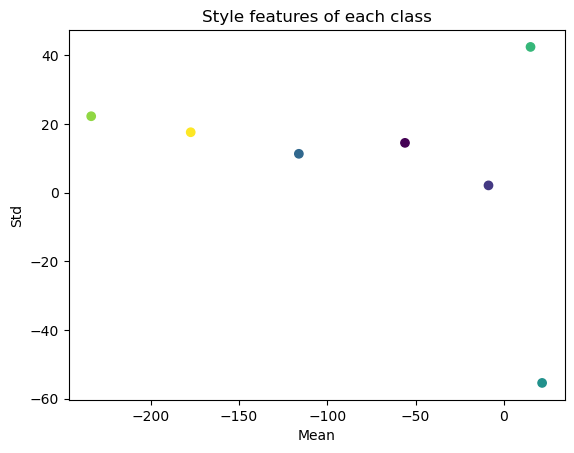

In [18]:
classes = np.arange(7)
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=classes)
# plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Style features of each class')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [19]:
tsne_data = np.hstack((total_mean, total_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

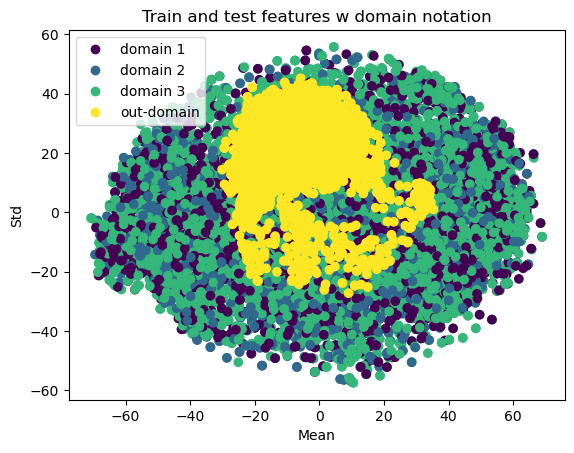

In [20]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Train and test features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [21]:
tsne_data = np.hstack((feats_mean, feats_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

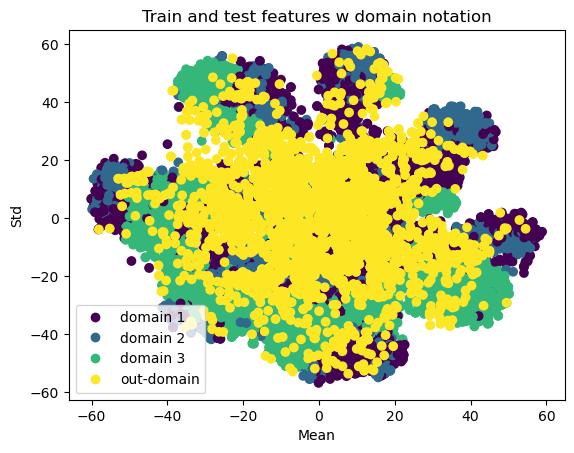

In [22]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Train and test features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

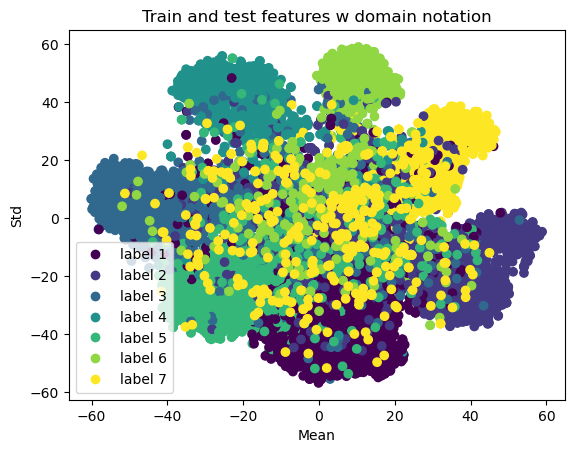

In [23]:
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=label_idx)
plt.title('Train and test features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [ ]:
id_feats_mean = np.mean(id_feats, axis=(2, 3))
id_feats_std = np.std(id_feats, axis=(2, 3))
tsne_data = np.hstack((id_feats_mean, id_feats_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

In [ ]:
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=id_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=label_idx)
plt.title('Correlation between features and labels of train domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [ ]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=id_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Correlation between features and domains of train domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [ ]:
# col_val = []
# for i in range(0,4):
#     domain_index = np.where(id_domains == i)[0]
#     c_labels = id_labels[domain_index]
#     val, counts = np.unique(c_labels, return_counts=True)
#     col_val.append(counts)

In [ ]:
# col_val

In [ ]:
# x = [i for i in range(7)]
# plt.bar(x, col_val[0], color='r')
# plt.bar(x, col_val[1], bottom=col_val[0], color='b')
# plt.bar(x, col_val[2], bottom=col_val[1]+col_val[0], color='g')
# plt.bar(x, col_val[3], bottom=col_val[2]+col_val[1]+col_val[0], color='y')
# plt.show()

In [ ]:
val, counts = np.unique(od_labels, return_counts=True)
x = [i for i in range(7)]
plt.bar(x, counts, color='r')
plt.show()

In [ ]:
od_feats_mean = np.mean(od_feats, axis=(2, 3))
od_feats_std = np.std(od_feats, axis=(2, 3))
tsne_data = np.hstack((od_feats_mean, od_feats_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

In [ ]:
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=od_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=label_idx)
plt.title('Correlation between features and labels of test domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [ ]:
od_feats_mean = np.mean(od_feats, axis=(2, 3))
od_feats_std = np.std(od_feats, axis=(2, 3))
tsne_data = np.hstack((od_feats_mean, od_feats_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

In [ ]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=od_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Correlation between features and domain of test domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()